In [126]:
import numpy as np
import scanpy as sc
from scipy.sparse import issparse
from scipy.spatial.distance import cdist

# synthetic_adata = sc.read_h5ad("onek1k_annotated_synthetic_all.h5ad")
synthetic_adata = sc.read_h5ad("synth.h5ad")
sc.pp.filter_cells(synthetic_adata, min_counts=10)
sc.pp.filter_genes(synthetic_adata, min_cells=3)
sc.pp.normalize_total(synthetic_adata, target_sum=1e4)
sc.pp.log1p(synthetic_adata)
synth_genes = synthetic_adata.var.index

train_adata = sc.read_h5ad("onek1k_annotated_train.h5ad")
train_adata = train_adata[:,synth_genes]
sc.pp.normalize_total(train_adata, target_sum=1e4)
sc.pp.log1p(train_adata)

holdout_adata = sc.read_h5ad("onek1k_annotated_test.h5ad")
holdout_adata = holdout_adata[:,synth_genes]
sc.pp.normalize_total(holdout_adata, target_sum=1e4)
sc.pp.log1p(holdout_adata)


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [155]:
import anndata as ad

train_adata.obs['dataset'] = 'train'
holdout_adata.obs['dataset'] = 'holdout'
synthetic_adata.obs['dataset'] = 'synth'
real_adata = ad.concat([train_adata, holdout_adata], join='inner')

real_ct4 = real_adata[real_adata.obs.cell_type==4]
synth_ct4 = synthetic_adata[synthetic_adata.obs.cell_type=='4']

In [336]:
from sklearn.metrics import roc_auc_score

def meanVarNonzero(A):
    mask = A != 0
    count_nonzero = mask.sum(axis=0)
    sum_nonzero = np.where(mask, A, 0).sum(axis=0)
    mean_nonzero = sum_nonzero / count_nonzero
    squared_diff = np.where(mask, (A - mean_nonzero)**2, 0)
    var_nonzero = squared_diff.sum(axis=0) / count_nonzero
    return mean_nonzero, var_nonzero
    
def sparseGenesMIA(realAdata, synthAdata, canPeekAtNumMembers=False, numGenes=10, excludeNSparsest=0):
    density = (realAdata.X != 0).mean(axis=0).A.flatten()
    genesByDensity = np.argsort(density)
    synthDensity = (synthAdata.X != 0).mean(axis=0).A.flatten()
    genesBySynthDensity = np.argsort(synthDensity)
    
    cols = realAdata.X.shape[1]
    var = np.empty(shape=cols)

    genesAdded = 0
    sparsestGenes = np.zeros((numGenes,), dtype='int')
    for geneInd in genesByDensity[excludeNSparsest:]:
        # If synth density is not greater than 0, Z score of record
        # w.r.t non-zero synth distribution will be undefined.
        if density[geneInd] > 0 and synthDensity[geneInd] > 0:
            sparsestGenes[genesAdded] = geneInd
            genesAdded += 1
        if genesAdded == numGenes:
            break
    if genesAdded != numGenes:
        raise Exception("Not enough non-zero genes")

    synthMean, synthVar = meanVarNonzero(synthAdata[:,sparsestGenes].X.A)

    cellZScore = {}
    realSparse = realAdata[:,sparsestGenes]
    synthSparse = synthAdata[:,sparsestGenes]
    nonZeroCellMask = (realSparse.X.mean(axis=1) != 0)

    numNonZero = nonZeroCellMask.sum()
    percentNonZero = numNonZero / realAdata.X.shape[0]
    #print(f"Detected {numNonZero} non-zero cells i.e. {percentNonZero:.2%}%")
    for ind in np.where(nonZeroCellMask)[0]:
        cellExpr = realSparse[ind].X.A.flatten()
        cellNonZeroInds = np.where(cellExpr != 0)
        # print(f"Cell expr shape {cellExpr.shape}")
        # print(f"Synth mean shape {synthMean.shape}")
        zScore = np.abs((synthMean[cellNonZeroInds] - cellExpr[cellNonZeroInds]) / synthVar[cellNonZeroInds])
        cellZScore[ind] = zScore.mean()

    cellsByZScore = sorted(cellZScore, key=lambda k: cellZScore[k])
    # print(f"Lowest z score: {cellsByZScore[0]} w/ z score {cellZScore[cellsByZScore[0]]}")
    # print(f"Min z score: {min(cellZScore.values())}")

    if canPeekAtNumMembers:
        numMembers = realSparse[cellsByZScore].obs.dataset.value_counts()['train']
    else:
        numMembers = len(cellsByZScore) // 2

    predMembers = cellsByZScore[:numMembers]
    actualLabels = [True if x == 'train' else False for x in realAdata[cellsByZScore].obs.dataset]
    predictedLabels = ([True] * numMembers) + ([False] * (len(cellsByZScore) - numMembers))
    auc = roc_auc_score(actualLabels, predictedLabels)
    
    return predMembers, auc

Computing CT 0
Computing CT 3
Computing CT 13
Computing CT 14
Computing CT 4
Computing CT 12
Computing CT 8
Computing CT 5


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Computing CT 6
Computing CT 1
Computing CT 10
Computing CT 9
Computing CT 2


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Computing CT 15


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


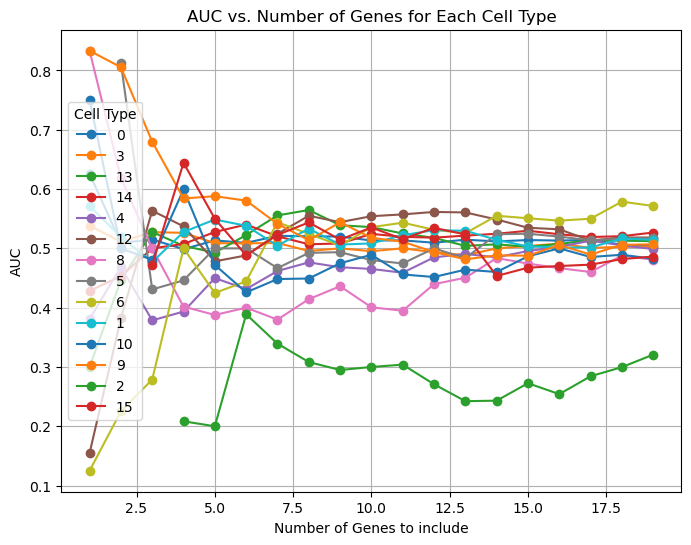

In [337]:
import matplotlib.pyplot as plt

num_genes_list = range(1, 20)
cell_types = real_adata.obs.cell_type.unique()
results = {ct: [] for ct in cell_types}
for ct in cell_types:
    print(f"Computing CT {ct}")
    for n in num_genes_list:
        real_cti = real_adata[real_adata.obs.cell_type==ct]
        synth_cti = synthetic_adata[synthetic_adata.obs.cell_type==str(ct)]
        predMembers, auc = sparseGenesMIA(
            real_cti, synth_cti, numGenes=n, canPeekAtNumMembers=False, excludeNSparsest=0
        )
        results[ct].append(auc)
        #print(f"numGenes={n}, AUC={auc:.4f}")

plt.figure(figsize=(8, 6))
for ct in cell_types:
    plt.plot(num_genes_list, results[ct], marker='o', label=ct)

plt.title("AUC vs. Number of Genes for Each Cell Type")
plt.xlabel("Number of Genes to include")
plt.ylabel("AUC")
plt.legend(title="Cell Type")
plt.grid(True)
plt.show()

In [338]:
from sklearn.metrics import roc_auc_score

aucs = []
for nGenes in range(1, 20):
    print(f"Trying {nGenes} genes")
    individualScores = {}
    for ind in real_adata.obs.individual.unique():
        individualScores[ind] = 0
    
    for ct in cell_types:
        real_cti = real_adata[real_adata.obs.cell_type==ct]
        synth_cti = synthetic_adata[synthetic_adata.obs.cell_type==str(ct)]
        predMembers, auc = sparseGenesMIA(
            real_cti, synth_cti, numGenes=nGenes, canPeekAtNumMembers=False, excludeNSparsest=0
        )
    
        for predMember in predMembers:
            associatedIndividual = real_cti[predMember].obs.individual.iloc[0]
            individualScores[associatedIndividual] += 1
    
    for ind in real_adata.obs.individual.unique():
        numCells = real_adata[real_adata.obs.individual==ind].n_obs
        individualScores[ind] /= numCells
    
    actualLabels = {}
    for ind in train_adata.obs.individual.unique():
        actualLabels[ind] = True
    
    for ind in holdout_adata.obs.individual.unique():
        actualLabels[ind] = False
    
    nonZeroScores = {}
    for k, v in individualScores.items():
        if v > 0:
            nonZeroScores[k] = v
    
    scores = np.array(list(nonZeroScores.values()))
    threshold = np.median(scores)
    
    predictions = {k: v >= threshold for k, v in nonZeroScores.items()}
    
    y_true = [actualLabels[k] for k in nonZeroScores.keys()]
    y_pred = [predictions[k] for k in nonZeroScores.keys()]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)

Trying 1 genes


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Trying 2 genes


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Trying 3 genes


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Trying 4 genes
Trying 5 genes
Trying 6 genes
Trying 7 genes
Trying 8 genes
Trying 9 genes
Trying 10 genes
Trying 11 genes
Trying 12 genes
Trying 13 genes
Trying 14 genes
Trying 15 genes
Trying 16 genes
Trying 17 genes
Trying 18 genes
Trying 19 genes


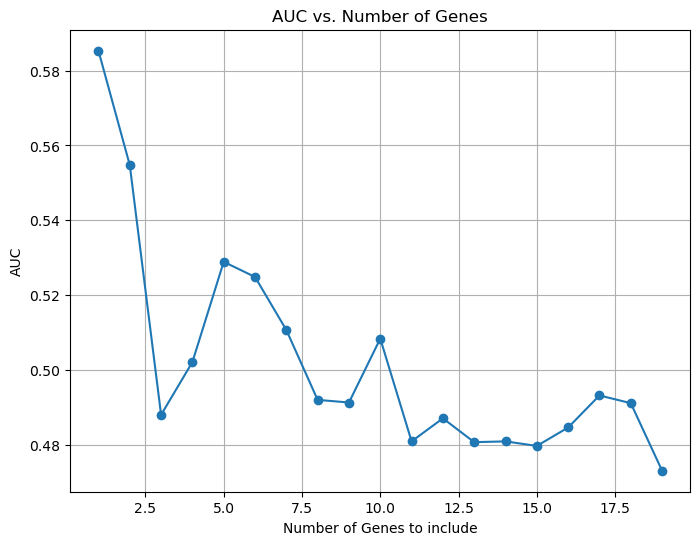

In [339]:
plt.figure(figsize=(8, 6))

plt.plot(range(1,20), aucs, marker='o')

plt.title("AUC vs. Number of Genes")
plt.xlabel("Number of Genes to include")
plt.ylabel("AUC")
plt.grid(True)
plt.show()